In [1]:
import numpy as np
from scipy.linalg import cho_solve, cho_factor
import matplotlib.pyplot as plt
import matplotlib
from scipy.interpolate import interp1d
cmap = 'bwr'

from PIL import Image

In [2]:
import h5py

[Group]   entry0
[Group]   entry0/D22
[Group]   entry0/D22/Distance
[Dataset] entry0/D22/Distance/det1_actual -> shape: (1,)
[Dataset] entry0/D22/Distance/det1_calc -> shape: (1,)
[Dataset] entry0/D22/Distance/det2_actual -> shape: (1,)
[Dataset] entry0/D22/Distance/det2_calc -> shape: (1,)
[Group]   entry0/D22/attenuator
[Dataset] entry0/D22/attenuator/attenuation -> shape: (1,)
[Dataset] entry0/D22/attenuator/position -> shape: (1,)
[Group]   entry0/D22/collimation
[Dataset] entry0/D22/collimation/actual_position -> shape: (1,)
[Dataset] entry0/D22/collimation/ap_size -> shape: (2,)
[Group]   entry0/D22/detector
[Dataset] entry0/D22/detector/det1_actual -> shape: (1,)
[Dataset] entry0/D22/detector/det1_calc -> shape: (1,)
[Dataset] entry0/D22/detector/det2_actual -> shape: (1,)
[Dataset] entry0/D22/detector/det2_calc -> shape: (1,)
[Group]   entry0/D22/selector
[Dataset] entry0/D22/selector/wavelength -> shape: (1,)
[Dataset] entry0/D22/selector/wavelength_res -> shape: (1,)
[Group] 

/tmp/ipykernel_52900/1967845294.py:66: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax.pcolormesh(qx, qy, I_diff, shading='auto', cmap=cmap, vmin=-2, vmax=2)


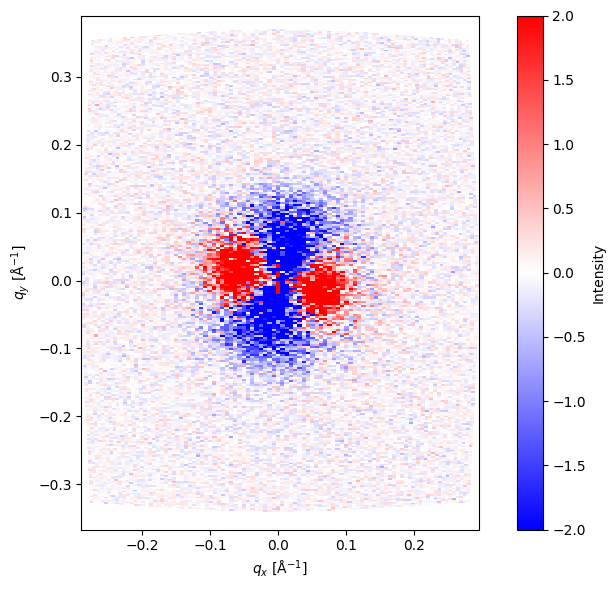

In [3]:
# try load one of the files to check if the data is accessible
filename = "./data/ILL_shear/000055.nxs" 
with h5py.File(filename, 'r') as f:
    # Explore the structure
    def print_tree(name, obj):
        if isinstance(obj, h5py.Dataset):
            print(f"[Dataset] {name} -> shape: {obj.shape}")
        else:
            print(f"[Group]   {name}")
    f.visititems(print_tree)
    sample_desc = f['/entry0/sample_description'][()]
    print("Sample description:", sample_desc[0].decode('utf-8'))

I_data_list = []
I_error_list = []

filename = "./data/ILL_shear/000500.nxs" 
with h5py.File(filename, 'r') as f:
    # Define dataset paths
    # path_data = '/entry0/data1/MultiDetector1_data'
    # path_error = '/entry0/data1/error1'
    # path_qx = '/entry0/data1/qx1'
    # path_qy = '/entry0/data1/qy1'
    
    path_data = '/entry0/data2/MultiDetector2_data'
    path_error = '/entry0/data2/error2'
    path_qx = '/entry0/data2/qx2'
    path_qy = '/entry0/data2/qy2'

    # Load and squeeze to remove singleton dimension
    I_data = np.squeeze(f[path_data][()])
    I_error = np.squeeze(f[path_error][()])
    qx = np.squeeze(f[path_qx][()])
    qy = np.squeeze(f[path_qy][()])
    I_data_list.append(I_data)
    I_error_list.append(I_error)

filename = "./data/ILL_shear/000505.nxs"     
with h5py.File(filename, 'r') as f:
    # Define dataset paths
    # path_data = '/entry0/data1/MultiDetector1_data'
    # path_error = '/entry0/data1/error1'
    # path_qx = '/entry0/data1/qx1'
    # path_qy = '/entry0/data1/qy1'
    
    path_data = '/entry0/data2/MultiDetector2_data'
    path_error = '/entry0/data2/error2'
    path_qx = '/entry0/data2/qx2'
    path_qy = '/entry0/data2/qy2'

    # Load and squeeze to remove singleton dimension
    I_data = np.squeeze(f[path_data][()])
    I_error = np.squeeze(f[path_error][()])
    qx = np.squeeze(f[path_qx][()])
    qy = np.squeeze(f[path_qy][()])
    I_data_list.append(I_data)
    I_error_list.append(I_error)
    
# Mask invalid intensity values (e.g., zeros or negatives)
I_diff = I_data_list[1] - I_data_list[0]
I_diff_err = np.sqrt(I_error_list[0]**2 + I_error_list[1]**2)

# Plot using object-oriented API
fig, ax = plt.subplots(figsize=(8, 6))

c = ax.pcolormesh(qx, qy, I_diff, shading='auto', cmap=cmap, vmin=-2, vmax=2)
# c2 = ax.pcolormesh(-qx, -qy, I_diff, shading='auto', cmap='viridis')
fig.colorbar(c, ax=ax, label='Intensity')

ax.set_xlabel(r'$q_x$ [$\mathrm{\AA}^{-1}$]')
ax.set_ylabel(r'$q_y$ [$\mathrm{\AA}^{-1}$]')
# ax.set_title('Scattering Intensity Map')
ax.set_aspect('equal')  # optional: square axes
plt.tight_layout()
plt.show()


## GPR

In [4]:
## Identification of principal axis 
def f_pl_obs(qx_obs, qy_obs, I_obs):
    qxqx = np.sum(I_obs * qx_obs * qx_obs)
    qxqy = np.sum(I_obs * qx_obs * qy_obs)
    qyqy = np.sum(I_obs * qy_obs * qy_obs)
    R = [[qxqx, qxqy], [qxqy, qyqy]]
    eigenvalues, eigenvectors = np.linalg.eig(R)
    principal_axis = eigenvectors[:, np.argmax(eigenvalues)]
    pl_eigen = np.arctan2(principal_axis[1], principal_axis[0])
    return pl_eigen

def f_C(theta, n, theta_0=0, bg=True):
    """
    Construct a symmetric cosine basis matrix evaluated at given angles.

    Parameters:
    - theta: array-like, angles where basis is evaluated (in radians)
    - n: number of non-constant cosine modes (n > 0)
    - theta_0: alignment angle for symmetry shift
    - bg: if True, include constant (isotropic) term in first column

    Returns:
    - C: (len(theta), n+1) array if bg=True, else (len(theta), n) array
    """
    theta = np.asarray(theta)
    theta_shift = theta - theta_0
    # n_list = 2 * (np.arange(n) + 1)  # modes: 2, 4, ..., 2n
    
    # Generate candidate p values: 1, 2, 3, 4, ..., and filter
    from sympy import isprime
    p_list = [p for p in range(1, 100) if p == 1 or isprime(p)]
    # Take the first `n` values
    p_list = p_list[:n]
    # Now generate n_list = 2 * p
    n_list = 2 * np.array(p_list)

    C_cos = np.cos(np.outer(theta_shift, n_list))  # shape (M, n)

    if bg:
        C_0 = np.ones((len(theta), 1))  # constant term
        C = np.concatenate([C_0, C_cos], axis=1)  # (M, n+1)
    else:
        C = C_cos  # (M, n)

    return C

def f_CS(theta, n, theta_0=0, bg=True):
    """
    Construct a real-valued Fourier basis with symmetric cosine and sine terms.

    Parameters:
    - theta: array-like, input angles in radians
    - n: number of cosine/sine harmonics (positive integers)
    - theta_0: alignment angle (shifts all basis functions)
    - bg: if True, include constant term as first column

    Returns:
    - C: (len(theta), 2n+1) if bg=True, else (len(theta), 2n)
         Columns ordered as [1, cos(2θ), ..., cos(2nθ), sin(2θ), ..., sin(2nθ)]
    """
    theta = np.asarray(theta)
    theta_shift = theta - theta_0
    # n_list = 2 * (np.arange(1, n + 1))  # modes: 2, 4, ..., 2n
    
    # Generate candidate p values: 1, 2, 3, 4, ..., and filter
    from sympy import isprime
    p_list = [p for p in range(1, 100) if p == 1 or isprime(p)]
    # Take the first `n` values
    p_list = p_list[:n]
    # Now generate n_list = 2 * p
    n_list = 2 * np.array(p_list)

    C_cos = np.cos(np.outer(theta_shift, n_list))  # (M, n)
    C_sin = np.sin(np.outer(theta_shift, n_list))  # (M, n)

    if bg:
        C_0 = np.ones((len(theta), 1))
        C = np.concatenate([C_0, C_cos, C_sin], axis=1)  # (M, 2n+1)
    else:
        C = np.concatenate([C_cos, C_sin], axis=1)       # (M, 2n)

    return C

def f_loglin(x, x_c=1):
    return np.where(x < x_c, (x-x_c)/x_c+np.log(x_c), np.log(x))
def f_loglin_inv(y, y_c=0):
    return np.where(y < y_c, (1+y-y_c)*np.exp(y_c), np.exp(y))

def bayesian_inference_ratio(I_obs, delta_I_obs, Q_obs, theta_obs, delta_Q, Q_eval, C_basis, mu_, lambda_,
                              mode="forward", log_transform=False, sine_basis=False, q_low=0.03, scale_low=0):
    """
    Perform Bayesian inference on the modulation I(Q, theta) / I_radial(Q).

    Parameters:
    - log_transform: if True, calculate the radial average on log I
    - sine_basis: if True, include sine basis functions
    - q_low: anisotropic coefficient vanishing at low q

    Returns:
    - A_MAP: MAP estimate of the harmonic coefficients (L x N)
    - I_radial_eval: estimated radial profile I_radial(Q_eval)
    """
    L = len(Q_eval)
    M = len(Q_obs)
    N = C_basis.shape[1]

    print(f"L (Q_eval): {L}, M (obs): {M}, N (basis): {N}")
    
    if log_transform:
        x_c = np.mean(I_obs)
        y_c = np.log(x_c)

        f_I = lambda I: f_loglin(I, x_c)
        f_inv_I = lambda fI: f_loglin_inv(fI, y_c)

        # --- Radial background estimation in transformed space ---
        fI_obs = f_I(I_obs)
        K_Qobs_to_Qeval = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
        W_Qeval_from_Qobs = K_Qobs_to_Qeval / K_Qobs_to_Qeval.sum(axis=0, keepdims=True)
        fI_radial_eval = W_Qeval_from_Qobs.T @ fI_obs  # shape (L,)
        I_radial_eval = f_inv_I(fI_radial_eval)

        # --- Project radial profile back to observations ---
        K_Qobs_from_Qeval = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
        W_Qobs_from_Qeval = K_Qobs_from_Qeval / K_Qobs_from_Qeval.sum(axis=1, keepdims=True)
        fI_radial_obs = W_Qobs_from_Qeval @ fI_radial_eval  # shape (M,)
        I_radial_obs = f_inv_I(fI_radial_obs)
    else:
        # --- Radial background estimation ---
        K_Qobs_to_Qeval = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
        W_Qeval_from_Qobs = K_Qobs_to_Qeval / K_Qobs_to_Qeval.sum(axis=0, keepdims=True)
        I_radial_eval = W_Qeval_from_Qobs.T @ I_obs  # shape (L,)

        # --- Project radial profile back to observations ---
        K_Qobs_from_Qeval = np.exp(-((Q_obs[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
        W_Qobs_from_Qeval = K_Qobs_from_Qeval / K_Qobs_from_Qeval.sum(axis=1, keepdims=True)
        I_radial_obs = W_Qobs_from_Qeval @ I_radial_eval  # shape (M,)
    

    # --- Normalize observations ---
    I_mod = I_obs / I_radial_obs
    delta_I_mod = delta_I_obs / I_radial_obs

    # --- Construct design matrix (M x LN) ---
    G = (K_Qobs_to_Qeval[:, :, None] * C_basis[:, None, :]).reshape(M, L * N)

    # --- Prior covariance ---
    Q_diff_sq = (Q_eval[:, None] - Q_eval[None, :]) ** 2
    K_spatial = np.exp(-Q_diff_sq / (2 * lambda_ ** 2))
    K_spatial_full = np.kron(np.eye(N), K_spatial)

    from sympy import isprime
    p_list = [p for p in range(1, 100) if p == 1 or isprime(p)]
    # Take the first `n` values
    p_list = p_list[:N-1]
    if sine_basis:
        p_list = [p for p in range(1, 100) if p == 1 or isprime(p)]
        p_list = p_list[:(N-1)//2]
        p_list = [val for p in p_list for val in (p, p)]
    # Now generate n_list = 2 * p
    angular_penalty = np.array([0] + [(2*n) for n in p_list])
    
    # angular_penalty = np.array([0] + [(2*n) for n in range(1, N)])
    K_angular = np.kron(np.diag(angular_penalty), np.eye(L))
    
    # --- Q-dependent penalty (decaying as Q^{-2}) for harmonics n >= 1 ---
    Q_penalty = np.zeros((L, N))
    Q_weight = q_low**2 / np.maximum((Q_eval-q_low)**2, 1e-6)  # avoid div-by-zero at Q = 0
    # Q_weight = np.exp(-Q_eval**2/2/q_low**2)  # exponential decay for low Q

    for j in range(1, N):
        Q_penalty[:, j] = Q_weight

    # Flatten to a diagonal penalty matrix
    K_lowQ = np.diag(Q_penalty.flatten())

    K_prior = K_spatial_full + K_angular + K_lowQ*scale_low

    # --- Prior mean ---
    A_prior_mean = np.zeros((L, N))
    A_prior_mean[:, 0] = 1.0 
    A_prior_flat = A_prior_mean.flatten()

    # --- Observation noise covariance ---
    Sigma = np.diag(delta_I_mod**2)

    # --- MAP Inference ---
    if mode == "forward":
        Sigma_inv = np.diag(1.0 / delta_I_mod**2)
        GT_Sinv = G.T @ Sigma_inv
        K_tilde_inv = GT_Sinv @ G + np.linalg.inv(K_prior) 
        K_tilde_inv = K_tilde_inv + 1e-6 * np.eye(K_tilde_inv.shape[0])
        rhs = GT_Sinv @ (I_mod - G @ A_prior_flat)
        # A_post_flat = A_prior_flat + cho_solve(cho_factor(K_tilde_inv), rhs)
        try:
            A_post_flat = A_prior_flat + cho_solve(cho_factor(K_tilde_inv), rhs)
        except np.linalg.LinAlgError:
            print("Cholesky failed, falling back to np.linalg.solve")
            A_post_flat = A_prior_flat + np.linalg.solve(K_tilde_inv, rhs)
        
    elif mode == "dual":
        residual = I_mod - G @ A_prior_flat
        G_K = G @ K_prior
        K_tilde = G_K @ G.T + Sigma
        A_post_flat = A_prior_flat + K_prior @ G.T @ cho_solve(cho_factor(K_tilde), residual)
    else:
        raise ValueError("mode must be 'forward' or 'dual'")

    A_MAP = A_post_flat.reshape(L, N)
    return A_MAP, I_radial_eval

def reconstruct_I_q(Q_eval, theta_eval, A_MAP, f_basis, mu_, theta_0=0.0,
                    direct=False, bg=True, I_radial_eval=None, log_transform=False, sine_basis = False):
    """
    Reconstruct the intensity modulation I(Q, theta)/I_radial(Q) or log-form.

    Parameters:
    - log_transform: If True, A_MAP represents log(I / I_radial)

    Returns:
    - I_modulated: shape (K, L), modulation (I / I_radial) or exp(log modulation)
    """
    L, N = A_MAP.shape
    K = len(theta_eval)

    # Angular basis matrix (K, N)
    C_arr = f_basis(theta_eval, N - 1 if bg else N, theta_0=theta_0, bg=bg)
    if sine_basis:
        C_arr = f_CS(theta_eval, (N - 1)//2 if bg else N//2, theta_0=theta_0, bg=bg)

    if direct:
        I_modulated = C_arr @ A_MAP.T  # (K, L)
    else:
        spatial_kernel_eval = np.exp(-((Q_eval[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))  # (L, L)
        I_modulated = (spatial_kernel_eval @ A_MAP) @ C_arr.T  # (L, K)
        I_modulated = I_modulated.T  # shape (K, L)

    # Restore full I(Q, theta) if bg was removed
    if not bg:
        if I_radial_eval is None:
            raise ValueError("Must provide I_radial_eval if bg=False")
        I_modulated *= I_radial_eval[None, :]  # elementwise multiply

    return I_modulated

def reconstruct_I_q_ratio(Q_eval, theta_eval, A_MAP, f_basis, mu_, I_radial_eval,
                          theta_0=0.0, direct=False, log_transform=False, sine_basis = False):
    """
    Reconstruct full I(Q, theta) from inferred modulation coefficients and radial profile.

    Parameters:
    - log_transform: If True, treat A_MAP as log(I/I_radial)

    Returns:
    - I_full: (K, L) reconstructed intensity I(Q, theta)
    - I_mod:  (K, L) modulation (I/I_radial) or exp(log modulation)
    """
    I_mod = reconstruct_I_q(
        Q_eval, theta_eval, A_MAP, f_basis, mu_,
        theta_0=theta_0, direct=direct, bg=True,
        I_radial_eval=None, log_transform=log_transform, sine_basis = sine_basis
    )

    I_full = I_mod * I_radial_eval[None, :]  # restore I(Q, theta)
    return I_full, I_mod


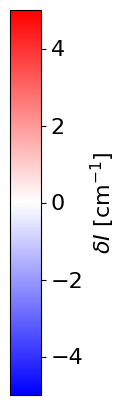

In [5]:
# Create a vertical colorbar according to the time list in viridis colormap
fig, ax = plt.subplots(figsize=(0.4, 5))
norm = plt.Normalize(vmin=-5, vmax=5)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, cax=ax)
cbar.set_label(r'$\delta I\ [\mathrm{cm}^{-1}]$', fontsize=16)
cbar.ax.tick_params(labelsize=16)

Sample description: TREATED: HQ CTAB at pos= 140.77 at rest 
Saved raw data to ./data/ILL_shear/raw_pos1_shear0.txt


/tmp/ipykernel_52900/1593240892.py:50: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax.pcolormesh(qx, qy, I_data, shading='auto', cmap='plasma', vmin=0, vmax=50)


L (Q_eval): 80, M (obs): 15193, N (basis): 11
(80, 11)
Saved inferred data to ./data/ILL_shear/infer_pos1_shear0.txt
Sample description: TREATED: HQ CTAB at pos= 140.77 at 10s-1
Saved raw data to ./data/ILL_shear/raw_pos1_shear1.txt
L (Q_eval): 80, M (obs): 15193, N (basis): 11


/tmp/ipykernel_52900/1593240892.py:50: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  c = ax.pcolormesh(qx, qy, I_data, shading='auto', cmap='plasma', vmin=0, vmax=50)


(80, 11)
Saved inferred data to ./data/ILL_shear/infer_pos1_shear1.txt
Sample description: TREATED: HQ CTAB at pos= 140.77 at 35s-1
Saved raw data to ./data/ILL_shear/raw_pos1_shear2.txt
L (Q_eval): 80, M (obs): 15193, N (basis): 11
(80, 11)
Saved inferred data to ./data/ILL_shear/infer_pos1_shear2.txt
Sample description: TREATED: HQ CTAB at pos= 140.77 at 80s-1
Saved raw data to ./data/ILL_shear/raw_pos1_shear3.txt
L (Q_eval): 80, M (obs): 15193, N (basis): 11
(80, 11)
Saved inferred data to ./data/ILL_shear/infer_pos1_shear3.txt
Sample description: TREATED: HQ CTAB at pos= 140.77 at 120s-1
Saved raw data to ./data/ILL_shear/raw_pos1_shear4.txt
L (Q_eval): 80, M (obs): 15193, N (basis): 11
(80, 11)
Saved inferred data to ./data/ILL_shear/infer_pos1_shear4.txt
Sample description: TREATED: HQ CTAB at pos= 140.77 at 240s-1
Saved raw data to ./data/ILL_shear/raw_pos1_shear5.txt
L (Q_eval): 80, M (obs): 15193, N (basis): 11
(80, 11)
Saved inferred data to ./data/ILL_shear/infer_pos1_shear5

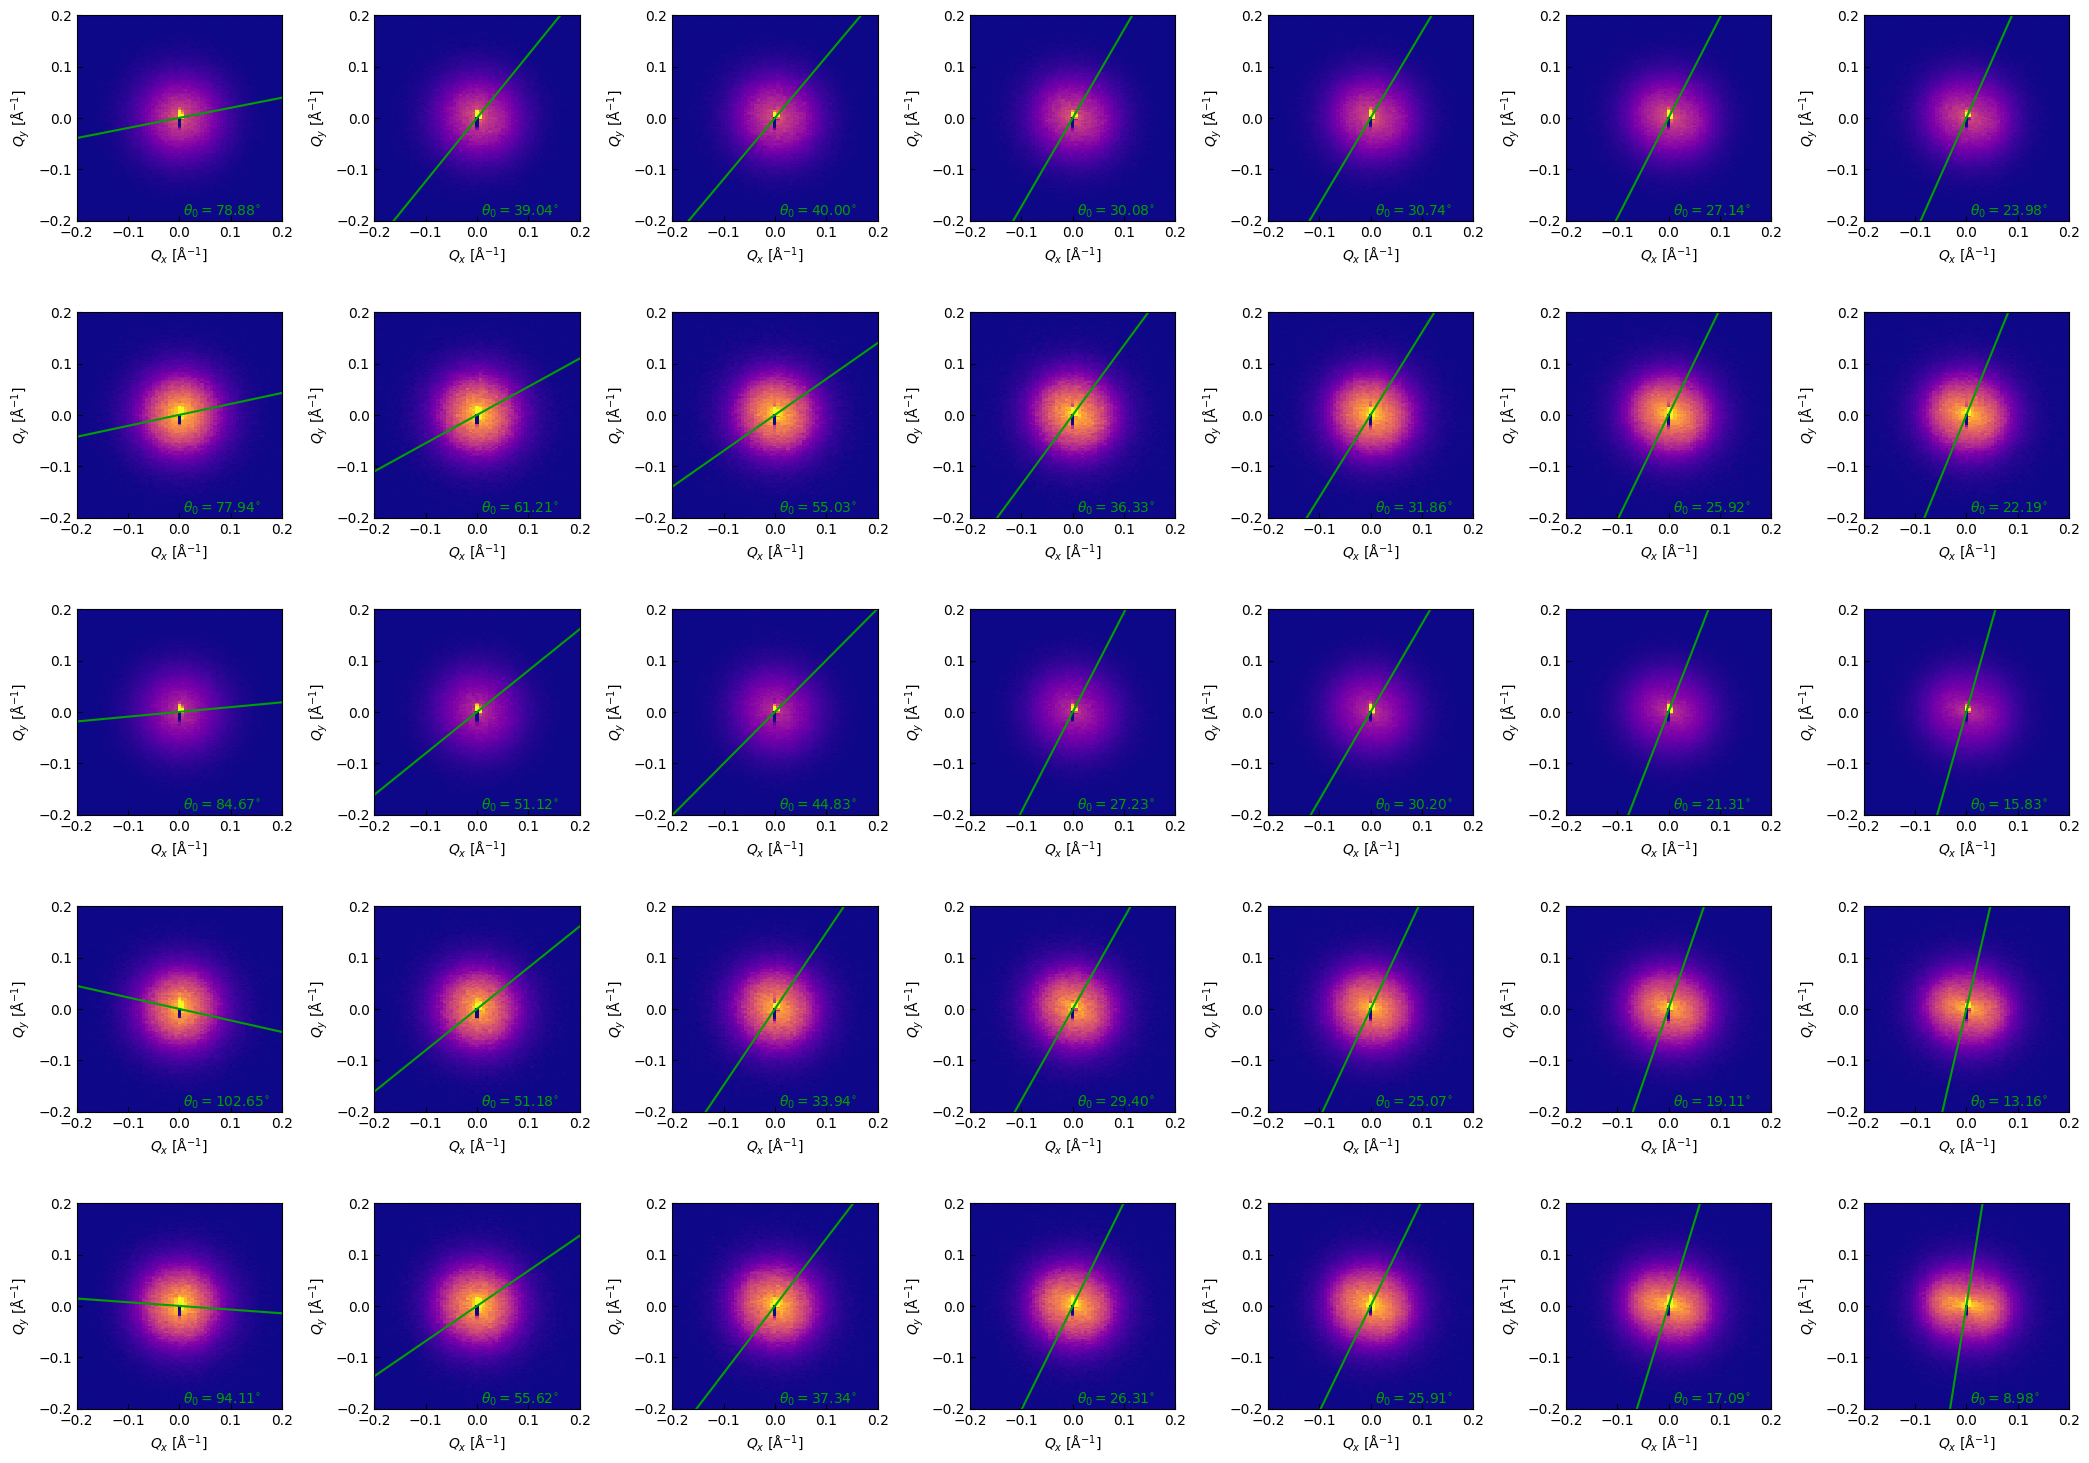

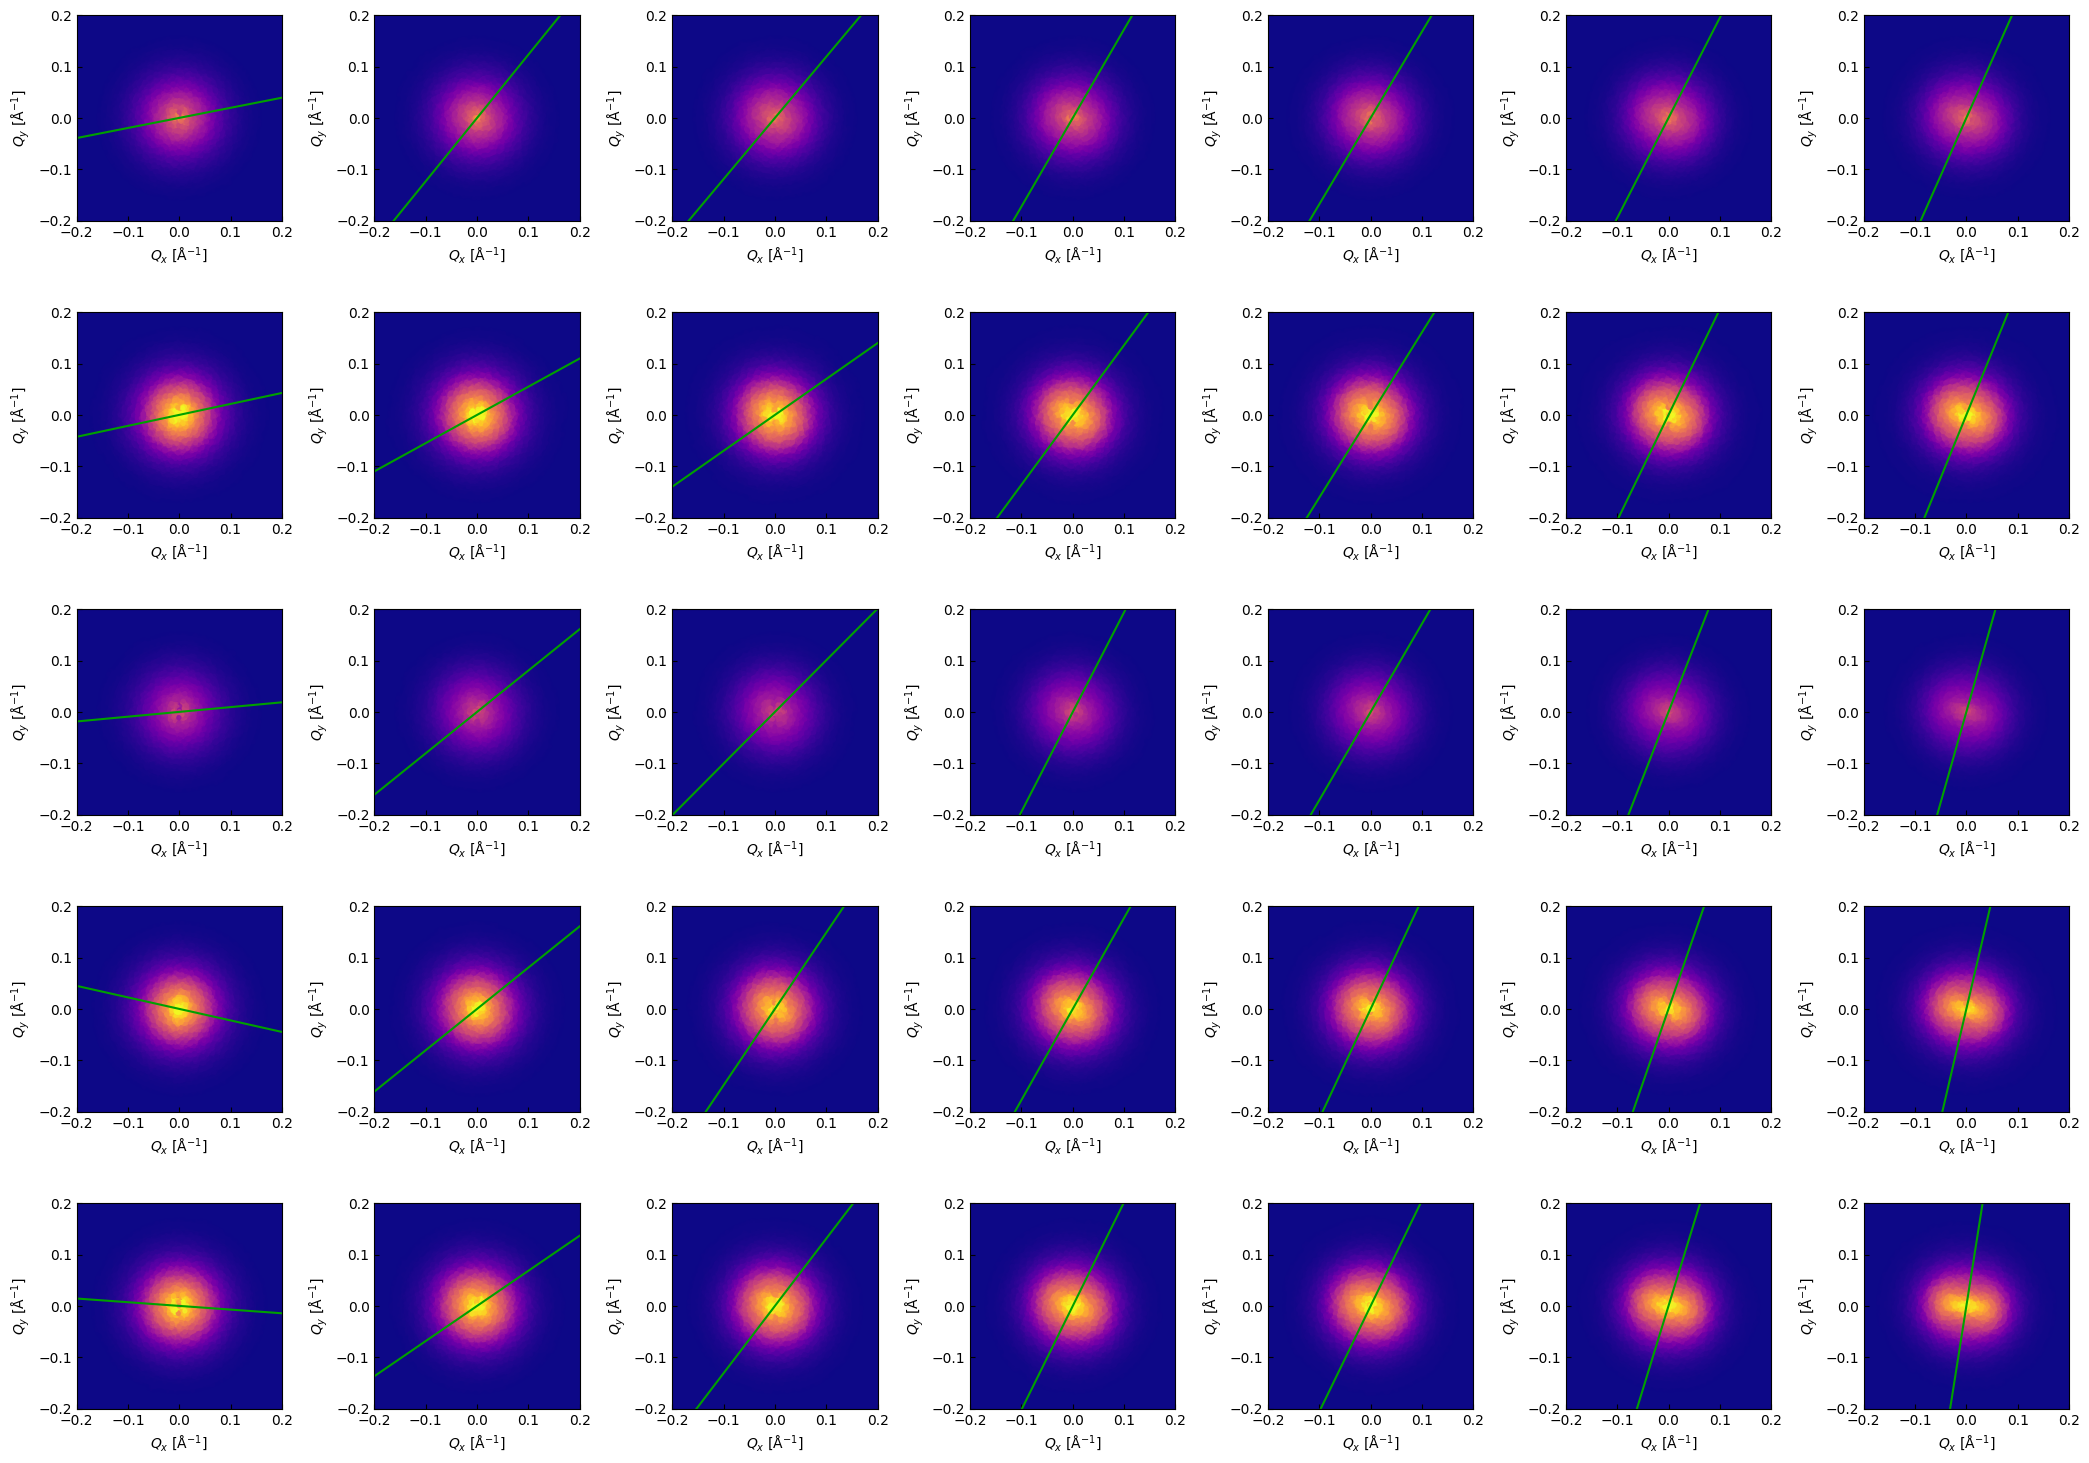

In [6]:
# do inference for all data
position_list = [1,2,3,4,5]
shear_list = [0,1,2,3,4,5,6]
# position_list = [5]
# shear_list = [6]
metadata_list = []
data_list = []

fig_1 = plt.figure(figsize=(21, 15))
fig_2 = plt.figure(figsize=(21, 15))
for index_p, position in enumerate(position_list):
    for index_shear, shear in enumerate(shear_list):    
        filename = f"./data/ILL_shear/000{position}0{shear}.nxs"
        with h5py.File(filename, 'r') as f:        
            path_data = '/entry0/data2/MultiDetector2_data'
            path_error = '/entry0/data2/error2'
            path_qx = '/entry0/data2/qx2'
            path_qy = '/entry0/data2/qy2'

            # Load and squeeze to remove singleton dimension
            I_data = np.squeeze(f[path_data][()])
            I_error = np.squeeze(f[path_error][()])
            qx = np.squeeze(f[path_qx][()])
            qy = np.squeeze(f[path_qy][()])
            I_data_list.append(I_data)
            I_error_list.append(I_error)
            sample_desc = f['/entry0/sample_description'][()]
            print("Sample description:", sample_desc[0].decode('utf-8'))

        data_list.append((I_data, I_error, qx, qy))
        metadata_list.append((position, shear))

        # Save results to a readable txt file
        output_filename = f"./data/ILL_shear/obs_pos{position}_shear{shear}.txt"
        # Save loaded raw data to a readable txt file
        with open(output_filename.replace("obs_", "raw_"), "w") as f_out:
            f_out.write(f"Sample description: {sample_desc[0].decode('utf-8')}\n")
            f_out.write(f"Position: {position}, Shear: {shear}\n")
            f_out.write("qx\tqy\tI_data\tI_error\n")
            for qxi, qyi, idi, ierr in zip(qx.flatten(), qy.flatten(), I_data.flatten(), I_error.flatten()):
                f_out.write(f"{qxi:.6f}\t{qyi:.6f}\t{idi:.6f}\t{ierr:.6f}\n")
        print(f"Saved raw data to {output_filename.replace('obs_', 'raw_')}")
        
        if index_shear == 0:
            I_data_0 = I_data

        # Plot using object-oriented API
        ax = fig_1.add_subplot(len(position_list), len(shear_list), index_p * len(shear_list) + index_shear + 1)

        c = ax.pcolormesh(qx, qy, I_data, shading='auto', cmap='plasma', vmin=0, vmax=50)
        # c2 = ax.pcolormesh(-qx, -qy, I_diff, shading='auto', cmap='viridis')
        # fig.colorbar(c, ax=ax, label='Intensity')

        # ax.set_title('Scattering Intensity Map')
        ax.set_facecolor('black')

        ax.set_xlabel(r'$Q_x$ [$\mathrm{\AA}^{-1}$]', fontsize=10)
        ax.set_ylabel(r'$Q_y$ [$\mathrm{\AA}^{-1}$]', fontsize=10)
        ax.set_xticks([-0.2, -0.1, 0, 0.1, 0.2])
        ax.set_yticks([-0.2, -0.1, 0, 0.1, 0.2])
        ax.tick_params(direction='in', labelsize=10)
        # Plot a line aligned with pl_eigen

        # ax.set_xlim(np.min(qx)*1.05, np.max(qx)*1.05)
        # ax.set_ylim(np.min(qx)*1.05, np.max(qx)*1.05)
        ax.set_xlim(-0.2, 0.2)
        ax.set_ylim(-0.2, 0.2)
        ax.set_aspect(1)
        ax.set_facecolor('black')
        
        # GPR ---------------------------------------------------------------
        qx_flat = qx.flatten()
        qy_flat = qy.flatten()
        I_data_flat = I_data.flatten()
        I_err_flat = I_error.flatten()

        Q_obs_all = np.sqrt(qx_flat**2 + qy_flat**2)
        theta_obs_all = np.arctan2(qy_flat, qx_flat)
        # Apply full mask as boolean condition
        valid = (Q_obs_all > 0.01) & (Q_obs_all < 0.3) & np.isfinite(I_data_flat) & np.isfinite(I_err_flat) & (I_err_flat < 6) 

        # Final filtered arrays (force regular ndarray)
        Q_obs = np.asarray(Q_obs_all[valid])
        theta_obs = np.asarray(theta_obs_all[valid])
        I_obs = np.asarray(I_data_flat[valid])
        delta_I_obs = np.asarray(I_err_flat[valid])
        I_sheared_obs = np.asarray(I_data_flat[valid])
        pl_eigen = f_pl_obs(Q_obs * np.cos(theta_obs), Q_obs * np.sin(theta_obs), I_sheared_obs)
        q_max = np.max(np.abs([np.min(qx), np.max(qx), np.min(qy), np.max(qy)]))
        x_line = np.array([-q_max, q_max])
        y_line = np.tan(pl_eigen+np.pi/2) * x_line
        ax.plot(x_line, y_line, color='#00A000', linestyle='-', linewidth=1.5, label='pl eigen')
        ax.text(0.52, 0.025, r"$\theta_0 = {:.2f}^{{\circ}}$".format(-np.degrees(pl_eigen)), color='#00A000', fontsize=10, fontweight='bold', transform=ax.transAxes)


        # Q for evaluation
        Q_eval = np.linspace(0, np.max(qx), 80)  # Define Q_eval range
        theta_eval = np.linspace(-np.pi, np.pi, 360, endpoint=False)
        # pl_eigen = np.pi/2  # Convert to radians

        # --- Step 3: Angular basis setup (include constant term for I/I_radial) ---
        n = 5
        bg = True  # Must include constant term
        C_arr = f_CS(theta_obs, n, theta_0=pl_eigen, bg=bg)

        # --- Step 4: Inference parameters ---
        lambda_ = 0.03
        mu_ = lambda_
        delta_Q = Q_eval[1] - Q_eval[0]
        log_transform = False  # <--- Enable log-transformed inference
        eps = 1e-8  # small positive number to prevent log(0) 

        # --- Step 5: Perform inference on log(I/I_radial) or I/I_radial ---
        A_MAP, I_radial_eval = bayesian_inference_ratio(
            I_obs, delta_I_obs, Q_obs, theta_obs,
            delta_Q, Q_eval, C_arr, mu_, lambda_,
            mode="dual",
            log_transform=log_transform, sine_basis = True, q_low=0.03, scale_low=0
        )
        print(A_MAP.shape)

        # --- Step 7: Reconstruct I(q, theta) ---
        I_eval, I_mod = reconstruct_I_q_ratio(
            Q_eval, theta_eval, A_MAP, f_CS, mu_,
            I_radial_eval, theta_0=pl_eigen, direct=False,
            log_transform=log_transform, sine_basis = True
        )
        
        # Inferred results ---------------------------------------------------------------
        # Total number of pixels (needed for normalization)
        # Evaluate grids and flat
        Q_eval_grid, theta_eval_grid = np.meshgrid(Q_eval, theta_eval)
        Qx_eval = Q_eval_grid * np.cos(theta_eval_grid)
        Qy_eval = Q_eval_grid * np.sin(theta_eval_grid)

        # flat
        I_eval_flat = I_eval.flatten()

        # Compute radial backgrounds
        I_eval_radial = np.mean(I_eval, axis=0)[None, :]
        I_eval_radial_flat = np.tile(I_eval_radial, (len(theta_eval), 1)).flatten()

        # Shuffle indices
        index_shuffle = np.arange(I_eval_flat.size)
        np.random.shuffle(index_shuffle)

        # Apply shuffle to everything
        theta_eval_flat = theta_eval_grid.flatten()[index_shuffle]
        Q_eval_flat = Q_eval_grid.flatten()[index_shuffle]
        Qx_eval_flat = Qx_eval.flatten()[index_shuffle]
        Qy_eval_flat = Qy_eval.flatten()[index_shuffle]
        I_eval_flat = I_eval_flat[index_shuffle]
        I_eval_radial_flat = I_eval_radial_flat[index_shuffle]
        
        if index_shear == 0:
            I_eval_flat_0 = I_eval_flat
            
        ax = fig_2.add_subplot(len(position_list), len(shear_list), index_p * len(shear_list) + index_shear + 1)
        sc = ax.scatter(Qx_eval_flat, Qy_eval_flat, c=I_eval_flat,
                        s=8, alpha=0.75, cmap='plasma', vmin=0, vmax=50)
        ax.plot(x_line, y_line, color='#00A000', linestyle='-', linewidth=1.5, label='pl eigen')
        ax.set_xlabel(r'$Q_x$ [$\mathrm{\AA}^{-1}$]', fontsize=10)
        ax.set_ylabel(r'$Q_y$ [$\mathrm{\AA}^{-1}$]', fontsize=10)
        ax.set_xticks([-0.2, -0.1, 0, 0.1, 0.2])
        ax.set_yticks([-0.2, -0.1, 0, 0.1, 0.2])
        ax.tick_params(direction='in', labelsize=10)

        # ax.set_xlim(np.min(qx)*1.05, np.max(qx)*1.05)
        # ax.set_ylim(np.min(qx)*1.05, np.max(qx)*1.05)
        ax.set_xlim(-0.2, 0.2)
        ax.set_ylim(-0.2, 0.2)
        ax.set_aspect(1)
        
        ax.set_facecolor('w')
        
        # Save inferred results to a readable txt file
        infer_output_filename = output_filename.replace("obs_", "infer_")
        with open(infer_output_filename, "w") as f_infer:
            f_infer.write(f"Sample description: {sample_desc[0].decode('utf-8')}\n")
            f_infer.write(f"pl_eigen (radians): {pl_eigen:.8f}\n")
            f_infer.write(f"Position: {position}, Shear: {shear}\n")
            f_infer.write("Q_eval_grid\ttheta_eval_grid\tI_eval\n")
            # Save I_eval as a grid, and also save Q_eval and theta_eval as vectors in the same file
            f_infer.write("\n# Q_eval (vector):\n")
            f_infer.write("\t".join([f"{q:.8f}" for q in Q_eval]) + "\n")
            f_infer.write("# I_radial_eval (vector):\n")
            f_infer.write("\t".join([f"{i:.8f}" for i in I_radial_eval]) + "\n")
            f_infer.write("# theta_eval (vector):\n")
            f_infer.write("\t".join([f"{t:.8f}" for t in theta_eval]) + "\n")
            f_infer.write("# I_eval (2D grid, shape: [len(theta_eval), len(Q_eval)]):\n")
            for row in I_eval:
                f_infer.write("\t".join([f"{val:.8f}" for val in row]) + "\n")

            # # Save the flattened results as before
            # for q_eval, theta_eval_val, i_eval in zip(Q_eval_grid.flatten(), theta_eval_grid.flatten(), I_eval.flatten()):
            #     f_infer.write(f"{q_eval:.6f}\t{theta_eval_val:.6f}\t{i_eval:.6f}\n")
        print(f"Saved inferred data to {infer_output_filename}")
        
fig_1.tight_layout() 
fig_2.tight_layout()   

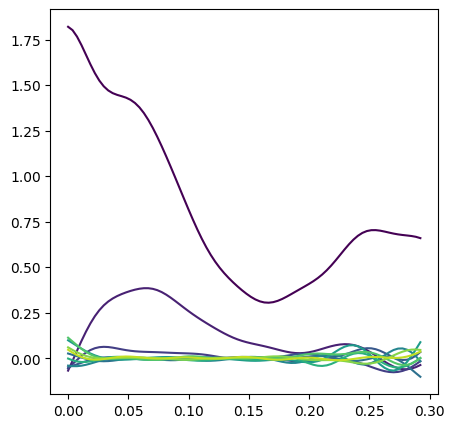

In [7]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

spatial_kernel_eval = np.exp(-((Q_eval[:, None] - Q_eval[None, :]) ** 2) / (2 * mu_ ** 2))
A_recon = spatial_kernel_eval @ A_MAP
for i_n in range(A_MAP.shape[1]):
    ax.plot(Q_eval, A_recon[:, i_n], label=f'Harmonic {i_n+1}', color=matplotlib.cm.get_cmap('viridis')(i_n / A_MAP.shape[1]))
    # ax.plot(Q_eval, I_radial_eval, label='Radial Profile', color='black', linestyle='--')

In [8]:
np.histogram(I_err_flat)

(array([24565,     6,     0,     2,     0,     0,     2,     0,     0,
            1]),
 array([ 0.        ,  6.28630614, 12.57261228, 18.85891843, 25.14522457,
        31.43153071, 37.71783685, 44.00414299, 50.29044914, 56.57675528,
        62.86306142]))